In [2]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost model
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # SHAP library for feature importance analysis

# Deep learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

In [8]:
# Load the dataset with semicolon delimiter
file_path = 'Dataset-SolarTechLab.csv'
data = pd.read_csv(
    file_path,
    delimiter=';',  # Specify the semicolon as the delimiter
    index_col=[0],  # Use 'Time' as the index
    parse_dates=[0]  # Parse the 'Time' column as datetime
)

data['G_tilt']= data['G_tilt'].ffill().bfill()

print(data.isna().sum())

PV_Power    326871
T_air         4854
G_h           4854
G_tilt           0
W_s           4854
W_d           4854
dtype: int64


In [9]:
# Now split the dataset into training and testing sets
split = int(len(data) * 0.7)
train, test = data.iloc[:split], data.iloc[split:]

### A closer look on the dataset

<Axes: title={'center': 'G_tilt'}, xlabel='Time'>

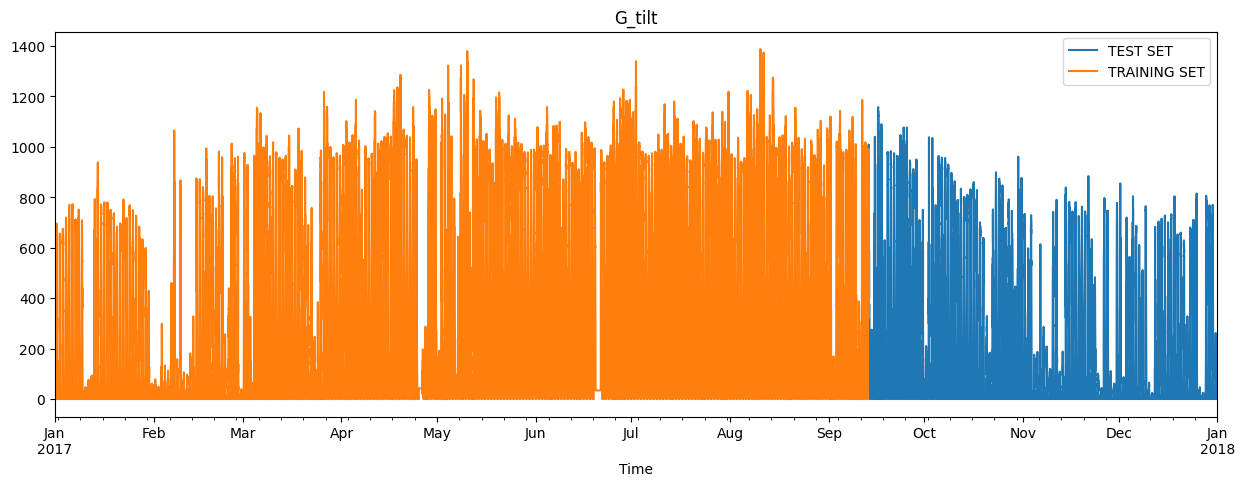

In [10]:
# Quick plotting of the Tilted Irradiance
test_set = test['G_tilt'].rename('TEST SET').to_frame()  # Convert Series to DataFrame
training_set = train['G_tilt'].rename('TRAINING SET').to_frame()  # Convert Series to DataFrame
combined_sets = test_set.join(training_set, how='outer')  # Combine the two DataFrames
combined_sets.plot(figsize=(15,5), title='G_tilt', style='-')  # Changed style to '-' to connect points

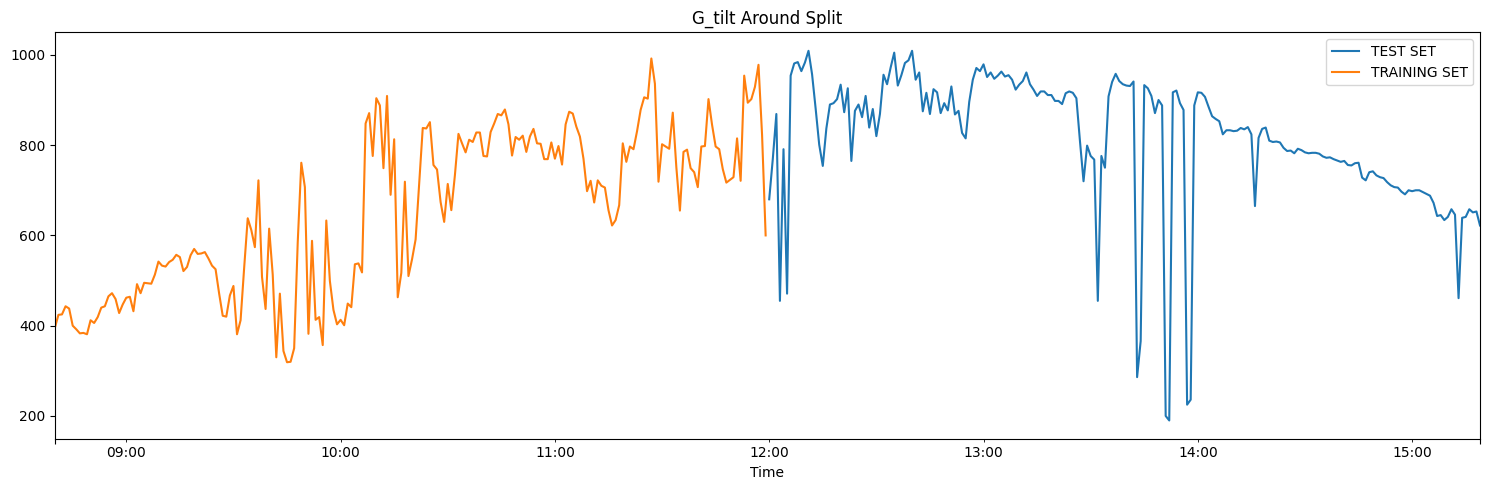

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'split' is the index used to split the data
# We have already split the dataset into train and test based on index 'split'

# Combine training and test sets into a single DataFrame
test_set = test['G_tilt'].rename('TEST SET').to_frame()  # Convert Series to DataFrame
training_set = train['G_tilt'].rename('TRAINING SET').to_frame()  # Convert Series to DataFrame
combined_sets = test_set.join(training_set, how='outer')  # Combine the two DataFrames

# Selecting only the 1000 data points around the split (split is an integer index here)
division_points = combined_sets.iloc[split-200:split+200]  # Use the integer index for slicing

# Plotting the selected points around the split
division_points.plot(figsize=(15, 5), title='G_tilt Around Split', style='-')
plt.tight_layout()
plt.show()


## Data splitting and K-fold cross validation

In [12]:
# Separate features and target
def separate_features_and_target(data, label=None):
    # Extract features (X) and target (y)
    X = data[['T_air','G_h','PV_Power','W_s','W_d']]  # Include engineered features
    if label:
        y = data[label]
        return X, y
    return X

# Create train and test datasets
X_train, y_train = separate_features_and_target(train, label='G_tilt')
X_test, y_test = separate_features_and_target(test, label='G_tilt')

## Models


In [13]:
# Apply ColumnTransformer for preprocessing to the dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['T_air','G_h','PV_Power','W_s','W_d']),  # Scale numerical features
    ]
)

In [14]:
# Scale Testing Data
X_test_scaled = preprocessor.fit_transform(X_test)


In [15]:
# Step 5: Define LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(60, activation='relu', return_sequences=True),
        Dropout(0.3),
        LSTM(80, activation='relu', return_sequences=True),
        Dropout(0.4),
        LSTM(120, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [16]:
# Step 6: Define XGBoost Parameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}


In [17]:
# Step 7: K-Fold Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_mean_errors = []
lstm_mean_errors = []


In [21]:
for train_idx, val_idx in kf.split(X_train):
    # Split Data for XGBoost (2D Data)
    X_train_cv = X_train.iloc[train_idx]
    y_train_cv = y_train.iloc[train_idx]
    X_val_cv = X_train.iloc[val_idx]
    y_val_cv = y_train.iloc[val_idx]

    # Preprocess Folds
    X_train_cv_scaled = preprocessor.fit_transform(X_train_cv)
    X_val_cv_scaled = preprocessor.transform(X_val_cv)

    # === XGBoost with GridSearchCV ===
    xgb_model = XGBRegressor()
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=kf,  # Use K-Fold object directly
        verbose=0
    
    )


    grid_search.fit(preprocessor.fit_transform(X_train), y_train)  # Use all training data for grid search
    best_xgb_model = grid_search.best_estimator_

    # Train on Current Fold with Best Parameters
    best_xgb_model.fit(X_train_cv_scaled, y_train_cv)
    y_val_pred_xgb = best_xgb_model.predict(X_val_cv_scaled)
    mse_xgb = mean_squared_error(y_val_cv, y_val_pred_xgb)
    xgb_mean_errors.append(mse_xgb)

    # === LSTM ===
    # Reshape Data for LSTM (3D Data)
    X_train_cv_scaled = X_train_cv_scaled.reshape(X_train_cv_scaled.shape[0], 1, X_train_cv_scaled.shape[1])
    X_val_cv_scaled = X_val_cv_scaled.reshape(X_val_cv_scaled.shape[0], 1, X_val_cv_scaled.shape[1])
    
    lstm_model = build_lstm_model((X_train_cv_scaled.shape[1], X_train_cv_scaled.shape[2]))
    lstm_model.fit(X_train_cv_scaled, y_train_cv, epochs=30, batch_size=32, verbose=0)
    y_val_pred_lstm = lstm_model.predict(X_val_cv_scaled).flatten()
    mse_lstm = mean_squared_error(y_val_cv, y_val_pred_lstm)
    lstm_mean_errors.append(mse_lstm)


KeyboardInterrupt: 

In [ ]:
# Step 9: Output Cross-Validation Results
xgb_mean_mse = np.mean(xgb_mean_errors)
xgb_std_mse = np.std(xgb_mean_errors)

lstm_mean_mse = np.mean(lstm_mean_errors)
lstm_std_mse = np.std(lstm_mean_errors)

print(f"XGBoost - Mean MSE: {xgb_mean_mse:.4f}, Std Dev: {xgb_std_mse:.4f}")
print(f"LSTM - Mean MSE: {lstm_mean_mse:.4f}, Std Dev: {lstm_std_mse:.4f}")



XGBoost - Mean MSE: nan, Std Dev: nan
LSTM - Mean MSE: nan, Std Dev: nan


c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Step 10: Final Test Evaluation
# Train Final XGBoost Model
final_xgb_model = XGBRegressor(**grid_search.best_params_)
final_xgb_model.fit(preprocessor.fit_transform(X_train), y_train)
xgb_test_pred = final_xgb_model.predict(preprocessor.transform(X_test))
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)

# Train Final LSTM Model
X_train_scaled = preprocessor.fit_transform(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
final_lstm_model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
final_lstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
lstm_test_pred = final_lstm_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])).flatten()
lstm_test_mse = mean_squared_error(y_test, lstm_test_pred)

print(f"Test Set Performance:")
print(f"XGBoost - Test MSE: {xgb_test_mse:.4f}")
print(f"LSTM - Test MSE: {lstm_test_mse:.4f}")


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
from xgboost import plot_tree
import graphviz

# Export a single decision tree to Graphviz
xgb_graph = final_xgb_model.get_booster().get_dump(dump_format="dot")[0]
graph = graphviz.Source(xgb_graph)
graph.render("xgb_tree", format="png", cleanup=True)
graph.view()

'xgb_tree.pdf'

## Plotting

Zoom range from 2017-11-01 00:00:00 to 2017-11-15 00:00:00 is not available in the data.


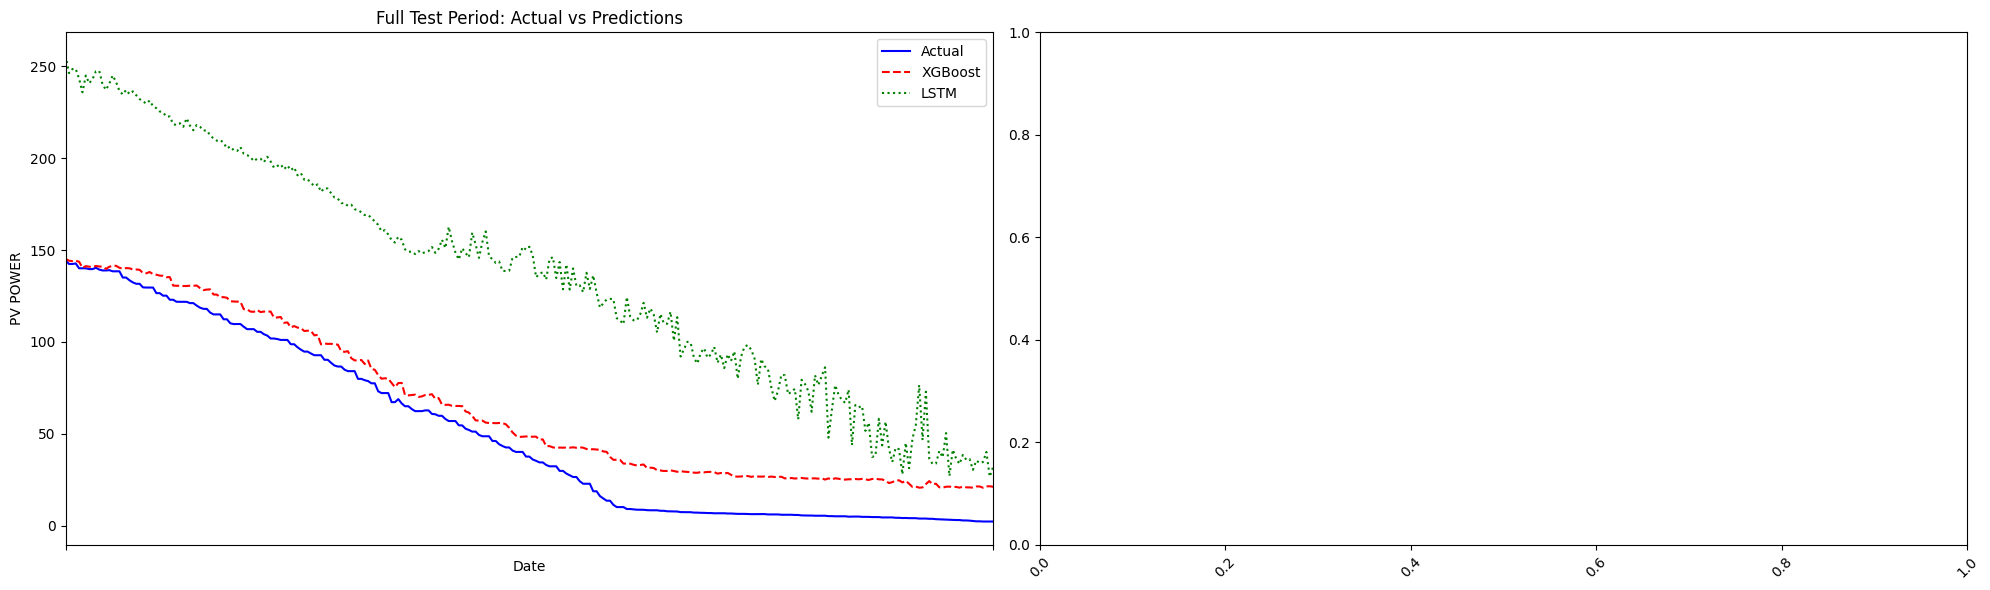

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming predictions are available from both models
# xgb_test_pred: Predictions from XGBoost
# lstm_test_pred: Predictions from LSTM
# y_test: Actual target values

# Combine predictions and actual values into a single DataFrame for easier plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'XGBoost Prediction': xgb_test_pred,
    'LSTM Prediction': lstm_test_pred
}, index=X_test.index)  # Ensure the index matches the test data for time alignment

# Make sure the index is a DatetimeIndex
results_df.index = pd.to_datetime(results_df.index)

# Plotting for the entire test period
f, ax = plt.subplots(1, 2, figsize=(20, 6))

# Left Plot: Full Test Period
results_df.plot(ax=ax[0], style=['-', '--', ':'], color=['blue', 'red', 'green'])
ax[0].set_title('Full Test Period: Actual vs Predictions')
ax[0].set_ylabel('G_tilt')
ax[0].set_xlabel('Date')
ax[0].legend(['Actual', 'XGBoost', 'LSTM'])

# Zoomed-in Plot
zoom_start = pd.to_datetime('2017-11-01')  # Adjust as needed
zoom_end = pd.to_datetime('2017-11-15')    # Adjust as needed

# Ensure the zoom range is valid and exists in the DataFrame index
if zoom_start in results_df.index and zoom_end in results_df.index:
    results_df.loc[zoom_start:zoom_end].plot(ax=ax[1], style=['-', '--', ':'], color=['blue', 'red', 'green'])
    ax[1].set_title('Zoomed-In: Actual vs Predictions (Nov-Dec 2019)')
    ax[1].set_ylabel('G_tilt')
    ax[1].set_xlabel('Date')
    ax[1].legend(['Actual', 'XGBoost', 'LSTM'])
else:
    print(f"Zoom range from {zoom_start} to {zoom_end} is not available in the data.")

# Optional: Rotate x-axis labels for better readability
for axis in ax:
    axis.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


TypeError: '<' not supported between instances of 'int' and 'Timestamp'

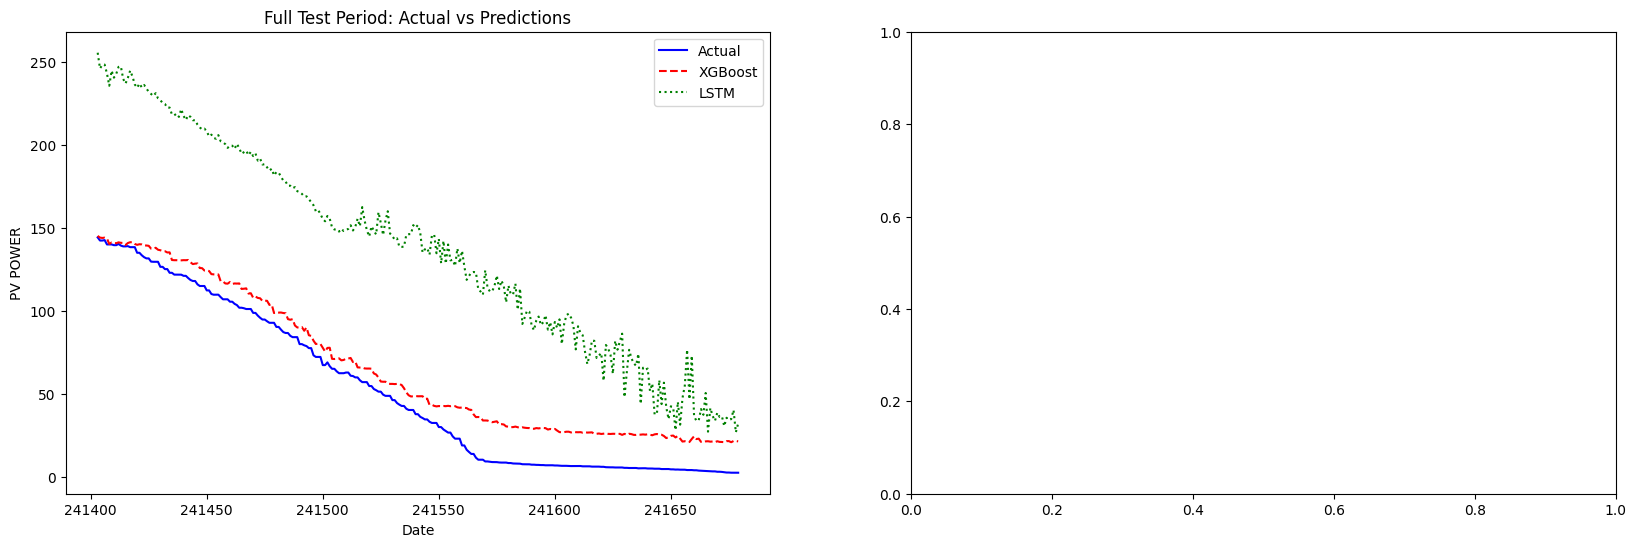

In [ ]:

# Combine predictions and actual values into a single DataFrame for easier plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'XGBoost Prediction': xgb_test_pred.flatten(),  # Flatten to convert from 2D array to 1D
    'LSTM Prediction': lstm_test_pred.flatten()  # Flatten to convert from 2D array to 1D
}, index=X_test.index)  # Ensure the index matches the test data for time alignment

# Plotting for the entire test period
f, ax = plt.subplots(1, 2, figsize=(20, 6))

# Left Plot: Full Test Period
results_df.plot(ax=ax[0], style=['-', '--', ':'], color=['blue', 'red', 'green'])
ax[0].set_title('Full Test Period: Actual vs Predictions')
ax[0].set_ylabel('PV POWER')
ax[0].set_xlabel('Date')
ax[0].legend(['Actual', 'XGBoost', 'LSTM'])

# Zoomed-in Plot
zoom_start = pd.to_datetime('2019-11-01')  # Adjust as needed
zoom_end = pd.to_datetime('2019-11-15')    # Adjust as needed

results_df.loc[zoom_start:zoom_end].plot(ax=ax[1], style=['-', '--', ':'], color=['blue', 'red', 'green'])
ax[1].set_title('Zoomed-In: Actual vs Predictions (Nov-Dec 2019)')
ax[1].set_ylabel('PV POWER')
ax[1].set_xlabel('Date')
ax[1].legend(['Actual', 'XGBoost', 'LSTM'])

# Optional: Rotate x-axis labels for better readability
for axis in ax:
    axis.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# === Plot for XGBoost ===
# Full Test Period
plt.figure(figsize=(15, 5))
xgb_results = pd.DataFrame({
    'Actual': y_test,
    'XGBoost Prediction': xgb_test_pred.flatten()
}, index=X_test.index)

xgb_results.plot(style=['-', '--'], color=['blue', 'red'])
plt.title('XGBoost: Full Test Period - Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('PV POWER')
plt.legend(['Actual', 'XGBoost Prediction'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Zoomed-In Period (November 2019)
plt.figure(figsize=(15, 5))
xgb_results.loc[zoom_start:zoom_end].plot(style=['-', '--'], color=['blue', 'red'])
plt.title('XGBoost: Zoomed-In (Nov 2019) - Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('PV POWER')
plt.legend(['Actual', 'XGBoost Prediction'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot for LSTM ===
# Full Test Period
plt.figure(figsize=(15, 5))
lstm_results = pd.DataFrame({
    'Actual': y_test,
    'LSTM Prediction': lstm_test_pred.flatten()
}, index=X_test.index)

lstm_results.plot(style=['-', '--'], color=['blue', 'green'])
plt.title('LSTM: Full Test Period - Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('PV POWER')
plt.legend(['Actual', 'LSTM Prediction'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Zoomed-In Period (November 2019)
plt.figure(figsize=(15, 5))
lstm_results.loc[zoom_start:zoom_end].plot(style=['-', '--'], color=['blue', 'green'])
plt.title('LSTM: Zoomed-In (Nov 2019) - Actual vs Prediction')
plt.xlabel('Date')
plt.ylabel('PV POWER')
plt.legend(['Actual', 'LSTM Prediction'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


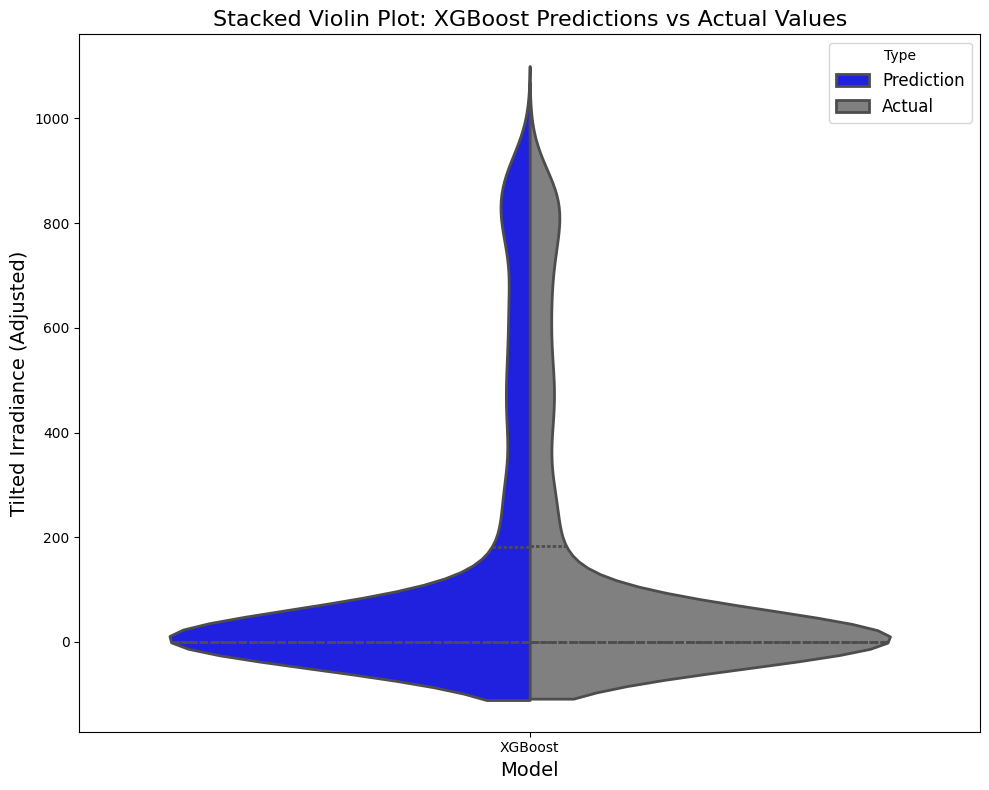

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for violin plot in long-form format
violin_data = pd.DataFrame({
    'Value': list(xgb_test_pred.flatten()) + list(y_test.to_numpy()),
    'Type': ['Prediction'] * len(xgb_test_pred.flatten()) +
            ['Actual'] * len(y_test.to_numpy()),
    'Category': ['XGBoost'] * (len(xgb_test_pred.flatten()) + len(y_test.to_numpy()))
})

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the 'Actual' values with dashed lines
sns.violinplot(data=violin_data, 
               x='Category', y='Value', hue='Type', 
               split=True, inner="quartile", linewidth=2,
               palette={"Prediction": "blue", "Actual": "gray"})

# Add title and labels
plt.title('Stacked Violin Plot: XGBoost Predictions vs Actual Values', fontsize=16)
plt.ylabel('PV POWER', fontsize=14)
plt.xlabel('Model', fontsize=14)

# Adjust legend
plt.legend(title='Type', fontsize=12)

plt.tight_layout()
plt.show()


## Performance metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you have the predictions from both models: xgb_test_pred and lstm_test_pred
# And the actual target values: y_test

# === XGBoost Model Metrics ===
# Mean Absolute Percentage Error (MAPE)
# Avoid dividing by zero by excluding points where y_test is 0
non_zero_mask = y_test != 0
mape_xgb = np.mean(np.abs((y_test[non_zero_mask] - xgb_test_pred[non_zero_mask]) / y_test[non_zero_mask])) * 100

# Mean Absolute Error (MAE)
mae_xgb = mean_absolute_error(y_test, xgb_test_pred)

# Mean Squared Error (MSE)
mse_xgb = mean_squared_error(y_test, xgb_test_pred)

# Root Mean Squared Error (RMSE)
rmse_xgb = np.sqrt(mse_xgb)

# R-squared (R²)
r2_xgb = r2_score(y_test, xgb_test_pred)

# === LSTM Model Metrics ===
# Mean Absolute Percentage Error (MAPE)
mape_lstm = np.mean(np.abs((y_test[non_zero_mask] - lstm_test_pred[non_zero_mask]) / y_test[non_zero_mask])) * 100

# Mean Absolute Error (MAE)
mae_lstm = mean_absolute_error(y_test, lstm_test_pred)

# Mean Squared Error (MSE)
mse_lstm = mean_squared_error(y_test, lstm_test_pred)

# Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mse_lstm)

# R-squared (R²)
r2_lstm = r2_score(y_test, lstm_test_pred)

# === Print the Results ===
print("XGBoost Model Metrics:")
print(f"MAPE: {mape_xgb:.4f}%")
print(f"MAE: {mae_xgb:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")
print("\n")

print("LSTM Model Metrics:")
print(f"MAPE: {mape_lstm:.4f}%")
print(f"MAE: {mae_lstm:.4f}")
print(f"MSE: {mse_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"R²: {r2_lstm:.4f}")


XGBoost Model Metrics:
MAPE: 5.8489%
MAE: 7.2780
MSE: 303.6926
RMSE: 17.4268
R²: 0.9956


LSTM Model Metrics:
MAPE: 95.2975%
MAE: 50.8353
MSE: 3713.2951
RMSE: 60.9368
R²: 0.9459


### SHAP 

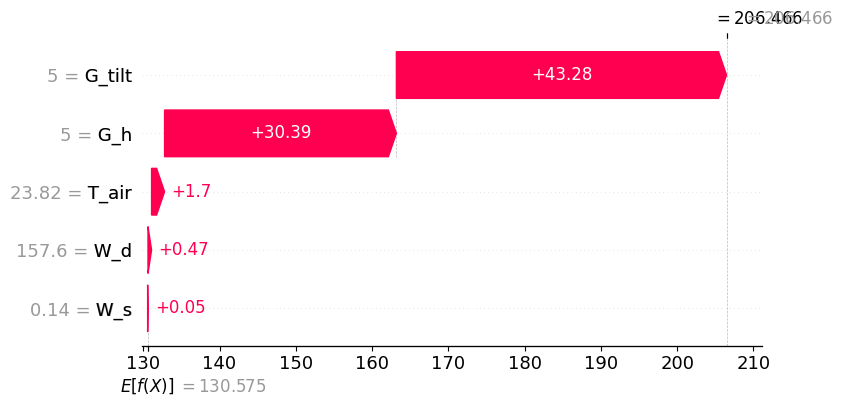

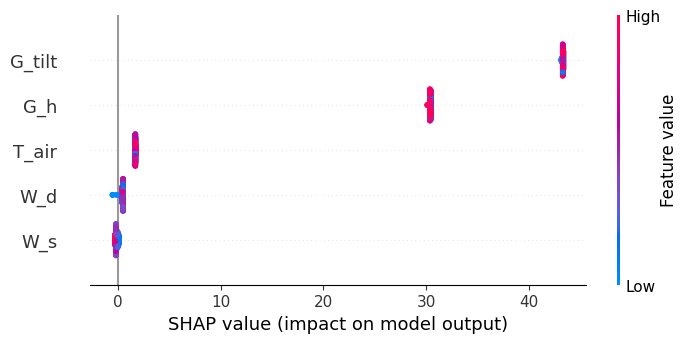

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

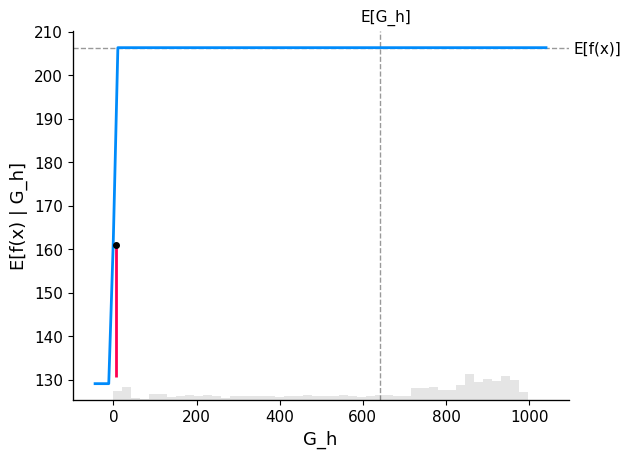

In [ ]:
# Create the SHAP explainer for the model
explainer = shap.Explainer(final_xgb_model)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)


# Step 1: Waterfall plot for a single sample
# This plot shows how each feature contributes to the model's prediction for a specific sample.
# Positive contributions (pushing the prediction higher) are shown in red, while negative contributions (pushing the prediction lower) are shown in blue.
# The final prediction is a combination of the base value (model's mean prediction) and the sum of these contributions.
sample_ind = 0  # Index of the sample you want to plot
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

# Step 2: Beeswarm plot for all features
# This plot provides an overview of the SHAP values for all features across the dataset.
# Each dot represents the impact of a single feature on a specific prediction.
# The horizontal spread shows the range of SHAP values for that feature, and color indicates the feature value (e.g., red for high values, blue for low).
shap.plots.beeswarm(shap_values)

# Step 3: Partial dependence plot (PDP) for a specific feature ("GHI" in this case)
# This plot shows the average model prediction for different values of the selected feature ("GHI").
# The solid line represents the PDP, illustrating how the prediction changes as the feature value varies.
# The overlayed SHAP values (from the sample) show the model's sensitivity to this feature for a particular instance.
fig, ax = shap.partial_dependence_plot(
    "G_h",  # You can change this to any feature from your dataset
    final_xgb_model.predict,
    X_train,  # Your feature data
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

# Step 4: SHAP Scatter Plot for a specific feature (e.g., 'GHI')
# This scatter plot displays the relationship between a specific feature's value and its SHAP value across all samples.
# Points are colored by another feature's SHAP value (or the same feature if not specified), allowing insights into interactions between features.
shap.plots.scatter(shap_values[:, "GHI"], color=shap_values)

# Step 5: Heatmap for a subset of the data
# The heatmap shows the SHAP values for multiple samples (e.g., the first 1000) across all features.
# Rows represent samples, and columns represent features.
# The color intensity indicates the magnitude of the SHAP value (red for positive impact, blue for negative impact).
shap.plots.heatmap(shap_values[:1000])  # You can adjust this slice


In [ ]:
for i, instance in enumerate(instances.values):
    shap.force_plot(
        explainer.expected_value, 
        shap_values.values[i], 
        feature_names=X.columns, 
        matplotlib=True
    )
    plt.title(f"Instance {i + 1}: Predicted = {shap_values.data[i]}, Actual = [YOUR_ACTUAL_VALUE]")
    plt.show()

# To summarize and visualize SHAP values across all three instances:
shap.summary_plot(shap_values.values, feature_names=X.columns, plot_type="bar")

# Analysis of MSE Difference between XGBoost and LSTM Models

The significant difference in Mean Squared Error (MSE) between **XGBoost** and **LSTM** could be attributed to several factors related to the models themselves, the data, and how they are trained. Here's a breakdown of the possible reasons for this discrepancy:

## 1. Model Characteristics

- **XGBoost** is a gradient boosting algorithm, a powerful tree-based method for regression tasks. It performs well with structured/tabular data and can capture complex relationships in the data efficiently, especially when fine-tuned through hyperparameter optimization.
- **LSTM (Long Short-Term Memory)** is a type of recurrent neural network (RNN) designed for sequential data, especially time-series. LSTMs excel at capturing long-term dependencies in sequences, but they might struggle when the relationships between input features are not sequential or have no strong temporal dependencies. If the data does not have strong sequential patterns, the LSTM might not perform as well as tree-based methods like XGBoost.

## 2. Data Characteristics

- **Data Preprocessing**: If the preprocessing steps for the LSTM and XGBoost models were not exactly the same (e.g., how you handle scaling or how you reshape the data), this could lead to differences in performance. For example, the LSTM requires reshaped 3D input (samples, timesteps, features), which might impact its performance, especially if the data is not truly sequential.
- **Feature Engineering**: Ensure that both models are using the same features, and the features are meaningful for both types of models. While XGBoost can often work well with engineered features, LSTM models might require more carefully constructed input features that better capture temporal patterns.

## 3. Model Hyperparameters

- **XGBoost Tuning**: If you have used **GridSearchCV** to fine-tune the hyperparameters for XGBoost, it might be more optimized for your data, leading to better performance and lower error.
- **LSTM Tuning**: LSTM networks often require more careful hyperparameter tuning (e.g., the number of layers, units, learning rate, batch size, epochs, dropout rates, etc.) and can be more sensitive to the chosen architecture. If the LSTM model is not tuned properly, it could underperform and produce higher errors.

## 4. Training Duration

- **Epochs and Batch Size**: LSTMs often require a longer training time (more epochs) to converge properly. If you used too few epochs or an inappropriate batch size, the model might not have learned the patterns effectively, leading to high errors.
- **Early Stopping**: If you didn't use early stopping or an appropriate validation set during training, the LSTM might have overfitted or not trained enough, leading to poor performance.

## 5. Overfitting or Underfitting

- **LSTM** might be overfitting to the training data, especially if it’s a small dataset or the model is too complex for the problem at hand. This could result in large variance in its predictions (as shown by the high standard deviation in MSE).
- **XGBoost**, on the other hand, is more regularized by default and could be better at generalizing from the data, especially with a proper hyperparameter search.

## 6. Scaling and Reshaping

- **Scaling**: While both models use scaling (via `StandardScaler()`), it is important to ensure that the scaling is applied correctly and consistently across all folds for both models. If the LSTM input is reshaped incorrectly, it might affect how the model learns the relationships between features.
- **Reshaping for LSTM**: The LSTM model expects data in 3D shape (samples, timesteps, features). If the reshaping is incorrect, it could lead to ineffective learning. Ensure that you reshape the data consistently and that the time steps (`1` timestep in this case) are meaningful for the LSTM.

## 7. Evaluation Metrics

- The MSE for LSTM could be high because it might not be capturing the relationships as effectively as XGBoost. It’s important to monitor the loss function during training (e.g., `mean_squared_error`) to ensure that the model is making progress and not diverging.
- You might also consider plotting the loss curves for LSTM during training to see if the model is underfitting or overfitting.

---

## Suggested Next Steps:

1. **Tune Hyperparameters** for both models, particularly the LSTM. This includes adjusting the number of layers, units, learning rates, and epochs.
2. **Check Data Preprocessing**: Ensure that the preprocessing steps are identical for both models and that the LSTM is receiving the data in the proper shape.
3. **Early Stopping for LSTM**: Consider using early stopping for LSTM to prevent overfitting.
4. **Compare Performance on Different Metrics**: If MSE is not a good fit for your task, try other metrics such as MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), or R2 to get a clearer understanding of the models' performances.

By addressing these points, you should be able to improve the LSTM's performance and potentially reduce the gap between it and XGBoost.


In [ ]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph()

# Add nodes representing the workflow steps
dot.node('A', 'Data Preprocessing')
dot.node('B', 'Feature Selection')
dot.node('C', 'K-Fold Cross-Validation')
dot.node('D', 'Model Training (XGBoost & LSTM)')
dot.node('E', 'Performance Evaluation')
dot.node('F', 'Comparison of Models')
dot.node('G', 'Explainability with SHAP')

# Add edges to represent the workflow
dot.edges([
    'AB',  # From Preprocessing to Feature Selection
    'BC',  # From Feature Selection to K-Fold Cross-Validation
    'CD',  # From K-Fold CV to Model Training
    'DE',  # From Model Training to Performance Evaluation
    'EF',  # From Evaluation to Model Comparison
    'FG'   # From Model Comparison to Explainability with SHAP
])

# Render the graph to a PNG file and automatically open it
dot.render('model_workflow', format='png', cleanup=True)  # Outputs 'model_workflow.png'
dot.view()  # Opens the generated graph in the default viewer


'model_workflow.pdf'